## Laboratorio de SIS421
El objetivo de este notebook es el de identificar prendas de vestir con una red neuronal convolucional(CNN) vasada en GoogLeNet o Inception https://arxiv.org/abs/1409.4842

In [18]:
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt
import numpy as np
import zipfile
import os
from tqdm import tqdm
from PIL import Image

device = "cuda" if torch.cuda.is_available() else "cpu"

Se utilizara un dataset formado a partir de otros dos datasets

1) https://www.kaggle.com/datasets/paramaggarwal/fashion-product-images-dataset

2) https://www.kaggle.com/datasets/agrigorev/clothing-dataset-full

El dataset contiene 67026 imagenes repartidas en 13 clases, cabe resaltar que se realizo aumento de datos (Data Augmentation), se genero 5 nuevas imagenes de cada imagen del dataset original que contenia 11171 imagenes

In [2]:
with zipfile.ZipFile('drive/MyDrive/Colab Notebooks/Clothing_dataset_2.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

In [46]:
data_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((112,112)),
    torchvision.transforms.ToTensor()
])
dataset = torchvision.datasets.ImageFolder('Clothing_dataset', transform=data_transform)
print('Imagenes:',len(dataset))
print('Numeros de clases:',len(os.listdir('Clothing_dataset')))

Imagenes: 67026
Numeros de clases: 13


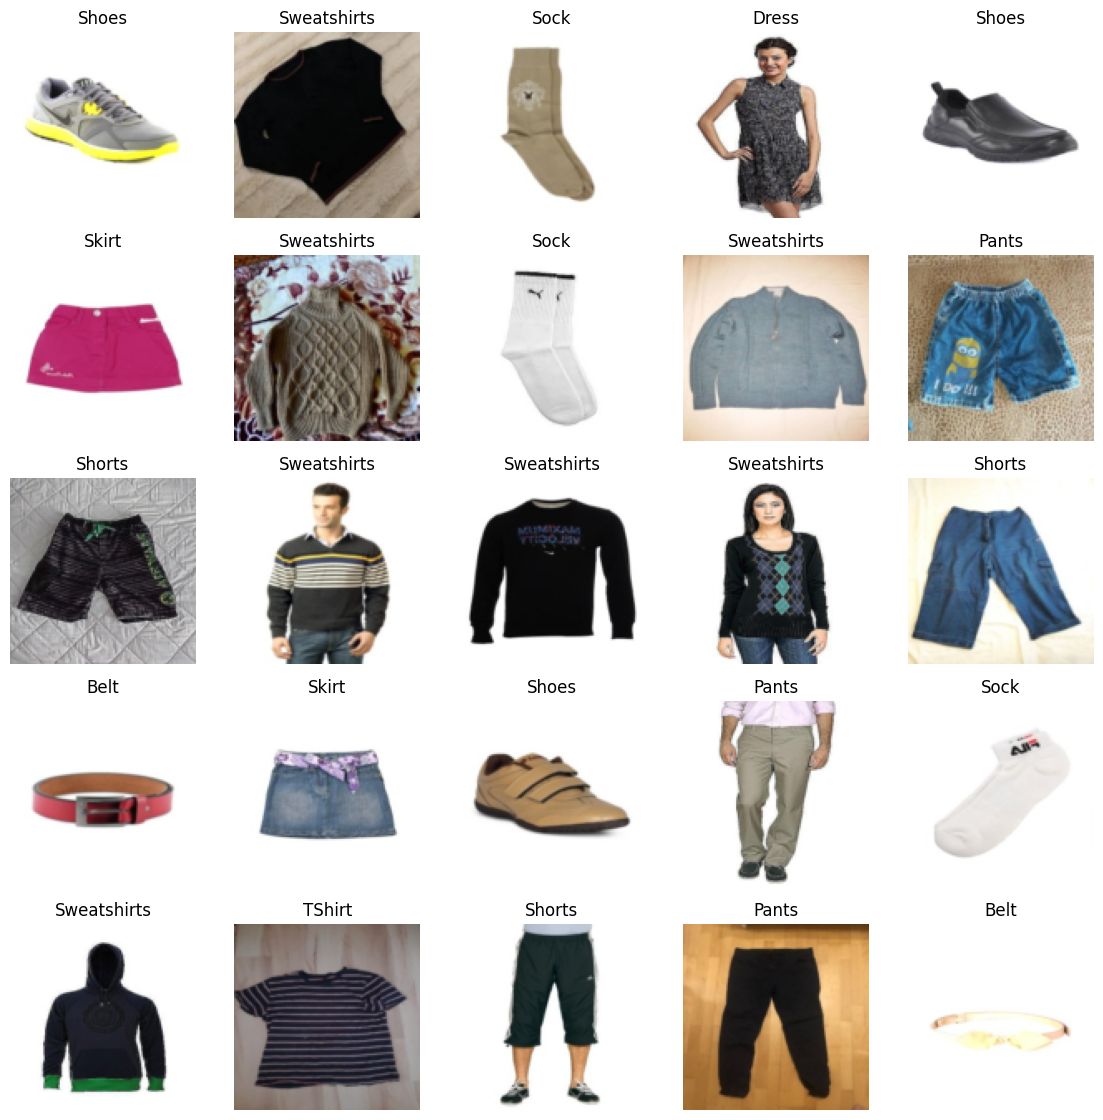

In [81]:
#classes = sorted(os.listdir('Clothing_dataset'), key=lambda x: x.lower())
classes = ['Belt','Briefs','Dress','Pants','Shirt','Shoes','Shorts','Skirt','Sock','Sweatshirts','TShirt','Tops','Undershirt']
fig, axs = plt.subplots(5,5, figsize=(14,14))
for _ax in axs:
  for ax in _ax:
    ix = random.randint(0, len(dataset)-1)
    img, lab = dataset[ix]
    ax.imshow(img.permute(1,2,0))
    ax.axis('off')
    ax.set_title(classes[lab])
plt.show()

Se genera un conjunto de entrenamiento y otro de prueva para poder valorar la eficacia del modelo

In [50]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
print('train size:',train_size)
print('test size:',test_size)
train_set, test_set = torch.utils.data.random_split(dataset, [train_size, test_size])

train size: 53620
test size: 13406


In [51]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=False)
dataloader = {
    'train': train_loader,
    'test': test_loader
}

In [52]:
imgs, labels = next(iter(train_loader))
print('Forma Xi:',imgs.shape,'|',labels.shape)

Forma Xi: torch.Size([32, 3, 112, 112]) | torch.Size([32])


## Modelo

**GoogLeNet**

Es una arquitectura de red neuronal convolucional(CNN) profunda que fue desarrollada por Google. Fue una de las primeras redes en utilizar el concepto de bloques Inception, que permite capturar características de diferentes escalas y resoluciones en paralelo.

**Componentes**

**BasicConv2d:** Es una red que realiza una operación de convolución seguida de normalización por lotes y, finalmente, aplica la función de activación ReLU.

**Capas Inception:** La innovación más destacada de GoogLeNet es el módulo Inception, que se utiliza en varias etapas de la arquitectura. En lugar de utilizar una única capa de convolución de tamaño fijo en cada etapa, el módulo Inception utiliza múltiples filtros de diferentes tamaños (por ejemplo, 1x1, 3x3) en paralelo y luego concatena sus salidas. Esto permite a la red aprender características en diferentes escalas y niveles de abstracción en paralelo, lo que conduce a una representación más rica de las imágenes.

**Capas InceptionAux:** GoogLeNet introduce capas InceptionAux en puntos estratégicos de la arquitectura para ayudar en la mitigación del desvanecimiento del gradiente y proporcionar una señal de retroalimentación adicional durante el entrenamiento. Estas capas ayudan a guiar los gradientes a través de la red de manera más efectiva y a reducir el riesgo de sobreajuste.

In [64]:
class BasicConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels, eps=0.001)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        return F.relu(x, inplace=True)

class Inception(nn.Module):
    def __init__(self, in_channels, ch1x1, ch3x3red, ch3x3, ch5x5red, ch5x5, pool_proj):
        super(Inception, self).__init__()
        # Branch 1:
        self.branch1 = BasicConv2d(in_channels, ch1x1, kernel_size=1)
        # Branch 2
        self.branch2 = nn.Sequential(
            BasicConv2d(in_channels, ch3x3red, kernel_size=1),
            BasicConv2d(ch3x3red, ch3x3, kernel_size=3, padding=1)
        )
        # Branch 3
        self.branch3 = nn.Sequential(
            BasicConv2d(in_channels, ch5x5red, kernel_size=1),
            BasicConv2d(ch5x5red, ch5x5, kernel_size=3, padding=1)
        )
        # Branch 4
        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1, ceil_mode=True),
            BasicConv2d(in_channels, pool_proj, kernel_size=1)
        )

    def forward(self, x):
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        branch3 = self.branch3(x)
        branch4 = self.branch4(x)
        return torch.cat([branch1, branch2, branch3, branch4], 1)


class InceptionAux(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.conv = BasicConv2d(in_channels, 128, kernel_size=1)
        self.fc1 = nn.Linear(2048, 1024)
        self.fc2 = nn.Linear(1024, num_classes)
        self.dropout = nn.Dropout(p=0.7)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        # aux1: B x 512 x 7 x 7, aux2: B x 528 x 7 x 7
        x = F.adaptive_avg_pool2d(x, (4, 4))# aux1: B x 512 x 4 x 4, aux2: B x 528 x 4 x 4
        x = self.conv(x)# B x 128 x 4 x 4
        x = torch.flatten(x, 1)# B x 2048
        x = F.relu(self.fc1(x), inplace=True)# B x 1024
        x = self.dropout(x)# B x 1024
        x = self.fc2(x)# N x (num_classes)
        #x = self.softmax(x)
        return x


class GoogLeNet(nn.Module):
    def __init__(self, num_classes=13):
        super(GoogLeNet, self).__init__()
        # Parte 1
        self.conv1 = BasicConv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True)
        self.conv2 = BasicConv2d(64, 64, kernel_size=1)
        self.conv3 = BasicConv2d(64, 192, kernel_size=3, padding=1)
        self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True)
        # Parte 2
        self.inception3a = Inception(192, 64, 96, 128, 16, 32, 32)
        self.inception3b = Inception(256, 128, 128, 192, 32, 96, 64)
        self.maxpool3 = nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True)
        self.inception4a = Inception(480, 192, 96, 208, 16, 48, 64)
        self.inception4b = Inception(512, 160, 112, 224, 24, 64, 64)
        self.inception4c = Inception(512, 128, 128, 256, 24, 64, 64)
        self.inception4d = Inception(512, 112, 144, 288, 32, 64, 64)
        self.inception4e = Inception(528, 256, 160, 320, 32, 128, 128)
        self.maxpool4 = nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True)
        self.inception5a = Inception(832, 256, 160, 320, 32, 128, 128)
        self.inception5b = Inception(832, 384, 192, 384, 48, 128, 128)
        self.aux1 = InceptionAux(512, num_classes)
        self.aux2 = InceptionAux(528, num_classes)
        # Parte 3
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(1024, num_classes)
        self.softmax = nn.Softmax(dim=1)
        # 64 capas entre conv y linear

    def forward(self, x):
        # B x 3 x 112 x 112
        x = self.conv1(x)# B x 64 x 56 x 56
        x = self.maxpool1(x)# B x 64 x 28 x 28
        x = self.conv2(x)# B x 64 x 28 x 28
        x = self.conv3(x)# B x 192 x 28 x 28
        x = self.maxpool2(x)# B x 192 x 14 x 14

        x = self.inception3a(x)# B x 256 x 14 x 14
        x = self.inception3b(x)# B x 480 x 14 x 14
        x = self.maxpool3(x)# B x 480 x 7 x 7
        x = self.inception4a(x)# B x 512 x 7 x 7
        aux1 = self.aux1(x)
        x = self.inception4b(x)# B x 512 x 7 x 7
        x = self.inception4c(x)# B x 512 x 7 x 7
        x = self.inception4d(x)# B x 528 x 7 x 7
        aux2 = self.aux2(x)
        x = self.inception4e(x)# B x 832 x 7 x 7
        x = self.maxpool4(x)# B x 832 x 4 x 4
        x = self.inception5a(x)# B x 832 x 4 x 4
        x = self.inception5b(x)# B x 1024 x 4 x 4

        x = self.avgpool(x)# B x 1024 x 1 x 1
        x = torch.flatten(x, 1)# B x 1024
        x = self.dropout(x)
        x = self.fc(x)# B x (num_classes)
        #x = self.softmax(x)
        return x, aux2, aux1

In [65]:
model = GoogLeNet()
y,a,b = model(torch.rand((32,3,112,112)))
y.shape

torch.Size([32, 13])

In [66]:
def fit(model, dataloader, epochs=5, lr=1e-3):
    print('Numero de parametros:',sum(p.numel() for p in model.parameters()))
    optimizer = torch.optim.Adamax(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()
    for epoch in range(1, epochs+1):
        model.train()
        train_loss, train_acc = [], []
        bar = tqdm(dataloader['train'])
        for batch in bar:
            X, y = batch
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat,a,b = model(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
            train_acc.append(acc)
            bar.set_description(f"loss {np.mean(train_loss):.5f} acc {np.mean(train_acc):.5f}")
        bar = tqdm(dataloader['test'])
        val_loss, val_acc = [], []
        model.eval()
        with torch.no_grad():
            for batch in bar:
                X, y = batch
                X, y = X.to(device), y.to(device)
                y_hat,a,b = model(X)
                loss = criterion(y_hat, y)
                val_loss.append(loss.item())
                acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
                val_acc.append(acc)
                bar.set_description(f"val_loss {np.mean(val_loss):.5f} val_acc {np.mean(val_acc):.5f}")
        print(f"Epoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} val_loss {np.mean(val_loss):.5f} acc {np.mean(train_acc):.5f} val_acc {np.mean(val_acc):.5f}")

In [67]:
model = GoogLeNet().to(device)
fit(model, dataloader, epochs=8)

Numero de parametros: 9969863


val_loss 0.51566 val_acc 0.82904: 100%|██████████| 419/419 [00:29<00:00, 14.27it/s]


Epoch 1/8 loss 0.65459 val_loss 0.51566 acc 0.77675 val_acc 0.82904


val_loss 0.25894 val_acc 0.90825: 100%|██████████| 419/419 [00:28<00:00, 14.63it/s]


Epoch 2/8 loss 0.29210 val_loss 0.25894 acc 0.90113 val_acc 0.90825


val_loss 0.19145 val_acc 0.93950: 100%|██████████| 419/419 [00:28<00:00, 14.75it/s]


Epoch 3/8 loss 0.17030 val_loss 0.19145 acc 0.94314 val_acc 0.93950


val_loss 0.12673 val_acc 0.96150: 100%|██████████| 419/419 [00:28<00:00, 14.73it/s]


Epoch 4/8 loss 0.10581 val_loss 0.12673 acc 0.96491 val_acc 0.96150


val_loss 0.08041 val_acc 0.97404: 100%|██████████| 419/419 [00:28<00:00, 14.57it/s]


Epoch 5/8 loss 0.07244 val_loss 0.08041 acc 0.97563 val_acc 0.97404


val_loss 0.07703 val_acc 0.97777: 100%|██████████| 419/419 [00:28<00:00, 14.68it/s]


Epoch 6/8 loss 0.05116 val_loss 0.07703 acc 0.98278 val_acc 0.97777


val_loss 0.07189 val_acc 0.97934: 100%|██████████| 419/419 [00:28<00:00, 14.65it/s]


Epoch 7/8 loss 0.03935 val_loss 0.07189 acc 0.98718 val_acc 0.97934


val_loss 0.06262 val_acc 0.98367: 100%|██████████| 419/419 [00:28<00:00, 14.56it/s]

Epoch 8/8 loss 0.02954 val_loss 0.06262 acc 0.99025 val_acc 0.98367


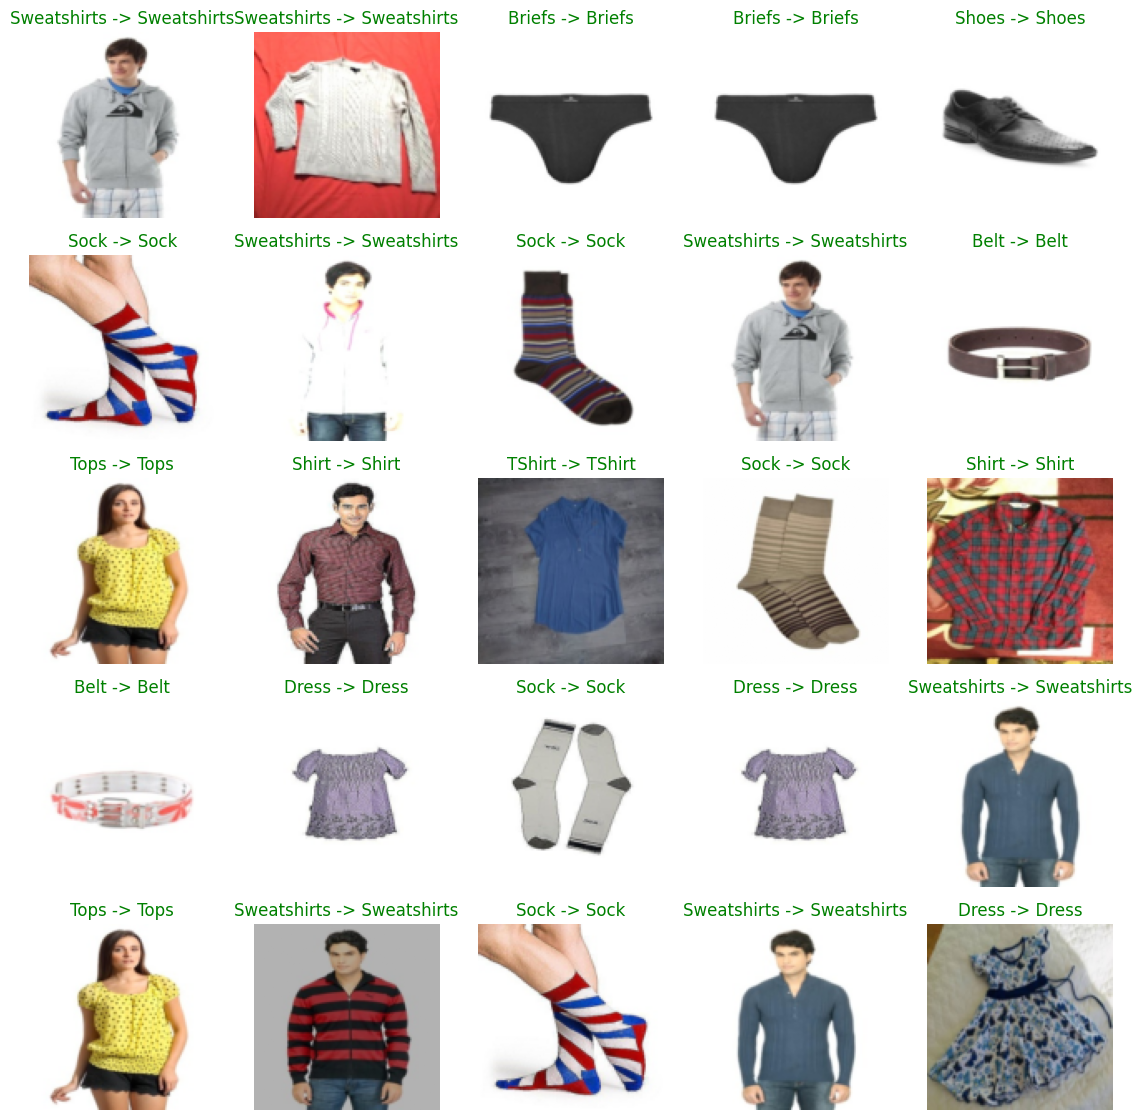

In [89]:
model.eval()
X,y = next(iter(test_loader))
y_hat,a,b = model(X.to(device))
y_hat = torch.argmax(y_hat, axis=1)
fig, axs = plt.subplots(5,5, figsize=(14,14))
for _ax in axs:
    for ax in _ax:
        ix = random.randint(0, 31)
        img, lab = X[ix], y_hat[ix]
        ax.imshow(img.permute(1,2,0))
        # pinta de verde el titulo si la predicción es correcta, de rojo si es incorrecta
        if y[ix] == lab:
            ax.set_title(f"{classes[lab]} -> {classes[y[ix]]}").set_color('green')
        else:
            ax.set_title(f"{classes[lab]} -> {classes[y[ix]]}").set_color('red')
        ax.axis('off')
plt.show()

Belt -> 0.0
Briefs -> 0.0
Dress -> 0.0
Pants -> 0.0
Shirt -> 0.0
Shoes -> 0.0
Shorts -> 0.0
Skirt -> 0.0
Sock -> 0.0
Sweatshirts -> 0.234
TShirt -> 0.766
Tops -> 0.0
Undershirt -> 0.0


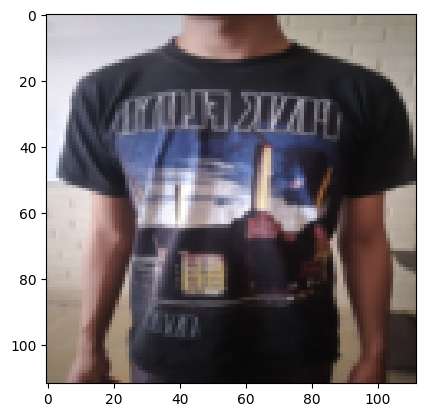

In [85]:
imagen = Image.open("imagenp.jpg")
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((112, 112)),
    torchvision.transforms.ToTensor()
])
imagen_tensor = transform(imagen)
imagen_tensor = imagen_tensor.transpose(1,2)
plt.imshow(imagen_tensor.permute(1,2,0))
X = imagen_tensor.unsqueeze(0)
model.eval()
out,_,_ = model(X.to(device))
out = F.softmax(out,dim=1)
y = out.tolist()[0]
for i,yj in enumerate(y):
    print(classes[i],'->',round(yj,3))